In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
%matplotlib inline
from helpers import *
import plotly.graph_objects as go

In [308]:
df_std = pd.read_csv("data_cleaned_standardized.csv", index_col=0)
df_clean = pd.read_csv("data_cleaned.csv", index_col=0)   

In [309]:
# Etienne le fait deja normalment #########################""
df_std.columns = df_std.columns.str.replace(' ', '')
df_std.columns = df_std.columns.str.replace('-', '')
df_std.columns = df_std.columns.str.replace('&', '')
df_std= df_std[df_std['Movie_box_office_scaled'].notna()]
df_std= df_std[df_std['Movie_runtime'].notna()]
df_std.reset_index(drop=True, inplace=True)

In [310]:
# 
df_std['Count'] = 1 # add a columns in order to sum by movies after and have the number of actors per movie
df_movies = df_std.copy()
df_movies = df_movies.drop(columns=['Actor_age_at_movie_release', 'Actor_height_scaled']) # drop useless columns
# groupby movie and sum all columns (also to have the number of actros and males per movie)
df_movies = df_movies.groupby('Movie_name').sum()
# divid to have a proportion of male and restore the movie properties except the count column
df_movies = df_movies.div(df_movies['Count'], axis=0) 
df_movies['Count'] = df_std.groupby('Movie_name')['Count'].sum()

df_movies_clean = df_movies.reset_index()
# add the balanced column that indicated whether the proportion of male and female in the movie is close enough +- 0.15
df_movies_clean['Balanced'] = ((df_movies_clean['Actor_gender_male'] <0.65) & (df_movies_clean['Actor_gender_male'] >0.35)).astype(int)


In [311]:

df_sample = df_movies_clean.copy().sample(n=1000, random_state = 25)

control_movie = df_sample[df_sample.Balanced == 0]
treat_movie =  df_sample[df_sample.Balanced == 1 ]

cutted = df_clean.groupby('Movie_name', as_index=False)['Movie_box_office_scaled'].mean()
# Merge to have the real Movie_box office (not scaled)
treat = pd.merge(treat_movie, cutted, on='Movie_name', how='left')
contr = pd.merge(control_movie, cutted, on='Movie_name', how='left')

#initialize figure
fig = go.Figure()
# plot the distribution of the box office for balanced and unbalanced movies
fig.add_trace(go.Histogram(x=treat['Movie_box_office_scaled_y'], histnorm='percent', name='Balanced', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=contr['Movie_box_office_scaled_y'], histnorm='percent', name='Unbalanced', marker_color='red', opacity=0.5))
#add title and labels
fig.update_layout(
    title='Movie box office distribution according to gender balance before matching',
    xaxis_title='Box office',
    yaxis_title='Percentage',
    barmode='overlay'
)

fig.show()
#store the html figure in plots
fig.write_html('.\plots\efore_matching_movies.html')

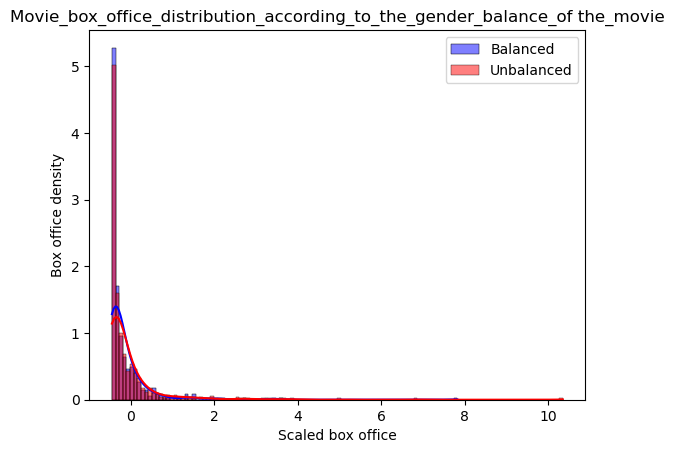

In [312]:
ax = sns.histplot(treat_movie['Movie_box_office_scaled'], kde=True, stat='density', color='blue', label='Balanced')
ax = sns.histplot(control_movie['Movie_box_office_scaled'], kde=True, stat='density', color='red', label='Unbalanced')
ax.set(title='Movie_box_office_distribution_according_to_the_gender_balance_of the_movie',xlabel='Scaled box office', ylabel='Box office density')
plt.legend()
plt.show()

In [313]:
"""#add 'Count' column to have the total number of actors per movie
df_std['Count'] = 1
# sum up the lines by movie ('count' gives the total number of actors and 'Actor_gender_male' give the proportion of male)
df_movies = (df_std.drop(columns=['Actor_age_at_movie_release', 'Actor_height_scaled']).groupby('Movie_name').sum())
df_movies['Count'] = df_std.groupby('Movie_name')['Count'].sum()
df_movies = df_movies.div(df_movies['Count'], axis=0)

# Add 'Balanced' column indicating if gender proportions are within +- 0.15
df_movies_clean['Balanced'] = ((df_movies_clean['Actor_gender_male'] < 0.65) & 
                                (df_movies_clean['Actor_gender_male'] > 0.35)).astype(int)
"""


"#add 'Count' column to have the total number of actors per movie\ndf_std['Count'] = 1\n# sum up the lines by movie ('count' gives the total number of actors and 'Actor_gender_male' give the proportion of male)\ndf_movies = (df_std.drop(columns=['Actor_age_at_movie_release', 'Actor_height_scaled']).groupby('Movie_name').sum())\ndf_movies['Count'] = df_std.groupby('Movie_name')['Count'].sum()\ndf_movies = df_movies.div(df_movies['Count'], axis=0)\n\n# Add 'Balanced' column indicating if gender proportions are within +- 0.15\ndf_movies_clean['Balanced'] = ((df_movies_clean['Actor_gender_male'] < 0.65) & \n                                (df_movies_clean['Actor_gender_male'] > 0.35)).astype(int)\n"

In [314]:
# Apply the regression and get the propensity score
mod = smf.logit(formula='Balanced ~ Movie_release_date + Movie_box_office_scaled \
                + C(Cluster_Name_CrimeThriller) + C(Cluster_Name_Drama) \
                + C(Cluster_Name_BWIndie) + C(Cluster_Name_ComedyAction) + C(Cluster_Name_ComedyShortfilm) \
                + C(Cluster_Name_DramaBW) + C(Cluster_Name_DramaComedy) + C(Cluster_Name_DramaIndie) + C(Cluster_Name_DramaRomance) + C(Cluster_Name_DramaThriller) + C(Cluster_Name_RomanceComedy) \
                + C(Cluster_Name_ShortfilmWorldcinema) + C(Cluster_Name_Thriller)', 
                data=df_movies_clean)

res = mod.fit()
df_movies_clean['Propensity_score'] = res.predict()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.629890
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Balanced   No. Observations:                 6416
Model:                          Logit   Df Residuals:                     6400
Method:                           MLE   Df Model:                           15
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                 0.04833
Time:                        17:41:33   Log-Likelihood:                -4041.4
converged:                       True   LL-Null:                       -4246.6
Covariance Type:            nonrobust   LLR p-value:                 4.279e-78
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 

([<matplotlib.axis.YTick at 0x1c17decad90>,
 [Text(0, 0, 'Movie_box_office_scaled'),
  Text(0, 1, 'C(Cluster_Name_ComedyShortfilm)[T.1.0]'),
  Text(0, 2, 'Movie_release_date'),
  Text(0, 3, 'C(Cluster_Name_CrimeThriller)[T.1.0]'),
  Text(0, 4, 'C(Cluster_Name_ComedyAction)[T.1.0]'),
  Text(0, 5, 'C(Cluster_Name_ShortfilmWorldcinema)[T.1.0]'),
  Text(0, 6, 'C(Cluster_Name_BWIndie)[T.1.0]'),
  Text(0, 7, 'C(Cluster_Name_DramaThriller)[T.1.0]'),
  Text(0, 8, 'C(Cluster_Name_Thriller)[T.1.0]'),
  Text(0, 9, 'C(Cluster_Name_DramaBW)[T.1.0]'),
  Text(0, 10, 'C(Cluster_Name_Drama)[T.1.0]'),
  Text(0, 11, 'C(Cluster_Name_DramaIndie)[T.1.0]'),
  Text(0, 12, 'C(Cluster_Name_DramaRomance)[T.1.0]'),
  Text(0, 13, 'C(Cluster_Name_DramaComedy)[T.1.0]'),
  Text(0, 14, 'C(Cluster_Name_RomanceComedy)[T.1.0]')])

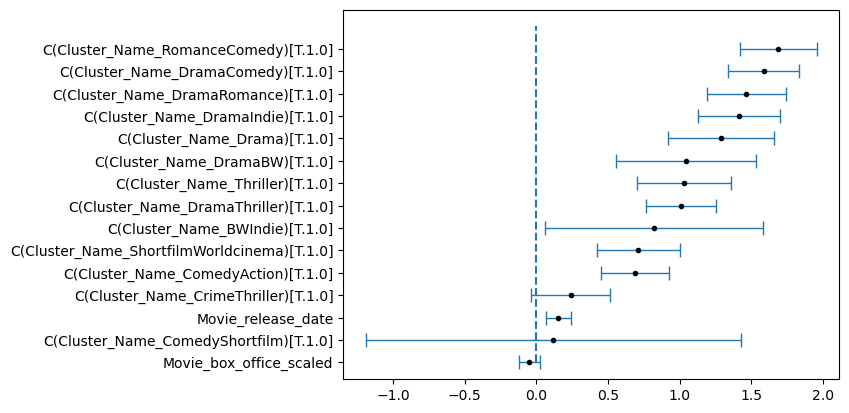

In [315]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2)

In [320]:
df_sample = df_movies_clean.copy().sample(n=600, random_state = 22)

control_movie = df_sample[df_sample.Balanced == 0]
treat_movie =  df_sample[df_sample.Balanced == 1 ]
#a ajouter dans helpers ############################################
def computediff(prop1,prop2): 
    return np.abs(prop1-prop2)
def compute_similarity(prop1,prop2):
    return 1-np.abs(prop1-prop2)

G_movies = nx.Graph()
for treat_id,treat_row in treat_movie.iterrows():
    for control_id, control_row in control_movie.iterrows():
        diff= computediff(control_row["Propensity_score"],treat_row["Propensity_score"])
        if (diff<0.05):
            similarity =  compute_similarity(control_row["Propensity_score"],treat_row["Propensity_score"])
            G_movies.add_weighted_edges_from([(control_id, treat_id, similarity)])
matching_movies = nx.max_weight_matching(G_movies)

print("Number of successful matching:",len(matching_movies))
print(matching_movies)

Number of successful matching: 231
{(1438, 5029), (2449, 305), (1565, 2226), (2402, 2789), (2269, 4203), (3096, 3569), (1126, 5110), (2324, 2708), (718, 2637), (3770, 4072), (2163, 759), (83, 631), (5160, 809), (1685, 2309), (221, 4476), (1300, 5909), (1576, 898), (3006, 1729), (4083, 5151), (4269, 5991), (3816, 1271), (1033, 2639), (4509, 3181), (1825, 3765), (1911, 1672), (5481, 4756), (340, 1357), (5269, 3598), (3364, 4856), (5922, 2723), (4488, 6105), (3173, 4758), (18, 3365), (1211, 1327), (4880, 6028), (43, 688), (3975, 5748), (2499, 6116), (3076, 441), (5167, 5465), (192, 3020), (2121, 3891), (2470, 2910), (2784, 6096), (6344, 484), (5415, 1085), (4020, 404), (4660, 3721), (5307, 1897), (2676, 1538), (1489, 3531), (1808, 4846), (607, 5699), (3256, 6381), (5615, 5814), (5903, 5152), (2946, 187), (1307, 2929), (4144, 128), (3146, 2585), (3057, 1998), (3408, 4254), (725, 5828), (3730, 1571), (2581, 2026), (349, 3481), (6400, 1311), (5944, 4805), (1706, 2027), (858, 1454), (4980, 11

In [321]:
matched_movies = [i[0] for i in list(matching_movies)] + [i[1] for i in list(matching_movies)]
paired_movies = df_movies_clean.iloc[matched_movies]

treated_movies = paired_movies.loc[paired_movies['Balanced'] == 1]
control_movies= paired_movies.loc[paired_movies['Balanced'] == 0]


In [322]:
cutted = df_clean.groupby('Movie_name', as_index=False)['Movie_box_office_scaled'].mean()
# Merge to have the real Movie_box office (not scaled)
treat = pd.merge(treated_movies, cutted, on='Movie_name', how='left')
contr = pd.merge(control_movies, cutted, on='Movie_name', how='left')

In [324]:
#initialize figure
fig = go.Figure()
# plot the distribution of the box office for balanced and unbalanced movies
fig.add_trace(go.Histogram(x=treat['Movie_box_office_scaled_y'], histnorm='percent', name='Balanced', marker_color='blue', opacity=0.5))
fig.add_trace(go.Histogram(x=contr['Movie_box_office_scaled_y'], histnorm='percent', name='Unbalanced', marker_color='red', opacity=0.5))
#add title and labels
fig.update_layout(
    title='Movie box office distribution according to gender balance after matching',
    xaxis_title='Box office',
    yaxis_title='Percentage',
    barmode='overlay'
)

fig.show()
#store the html figure in plots
fig.write_html('.\plots\matching_movies.html')

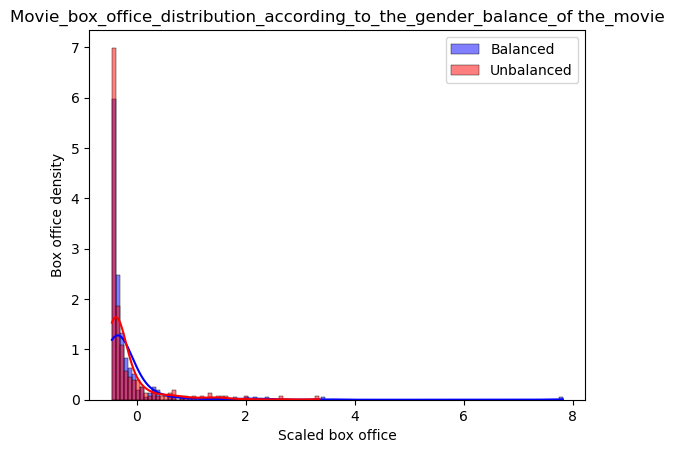

In [294]:
ax = sns.histplot(treated_movies['Movie_box_office_scaled'], kde=True, stat='density', color='blue', label='Balanced')
ax = sns.histplot(control_movies['Movie_box_office_scaled'], kde=True, stat='density', color='red', label='Unbalanced')
ax.set(title='Movie_box_office_distribution_according_to_the_gender_balance_of the_movie',xlabel='Scaled box office', ylabel='Box office density')
plt.legend()
plt.show()
